In [1]:
from transformers import AutoTokenizer, LlamaForCausalLM, CLIPProcessor, CLIPModel
import torch
from PIL import Image

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
llama_model = LlamaForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = "cuda"
llama_model.to(device)

prompt = "Hey, are you conscious? Can you talk to me?"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

generate_ids = llama_model.generate(inputs.input_ids, max_length=30)
tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

c:\Users\fvazquez\VSCodeProjects\EcoMobility\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\fvazquez\VSCodeProjects\EcoMobility\.venv\Lib\site-packages\transformers\models\llama\modeling_llama.py:655: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


"Hey, are you conscious? Can you talk to me?\n\nJASON: (sighs) Yeah, I'm conscious"

In [2]:
model_name = "PY007/TinyLlama-1.1B-step-50K-105b"
llama_model = LlamaForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = "cuda"
llama_model.to(device)


prompt = "What is the branch of the car?"
text_inputs = tokenizer(prompt, return_tensors="pt").to(device)

imput_embed = llama_model.get_input_embeddings()(text_inputs.input_ids)

generate_ids = llama_model.generate(inputs_embeds=imput_embed, max_length=20)
output_text = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

print(output_text)


The car is a 1996 Toy


In [3]:
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

clip_model.to(device)

image_path = "83.png"
image = Image.open(image_path)
inputs = clip_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    image_embeddings = clip_model.get_image_features(**inputs)

projection_layer =  torch.nn.Linear(512, 2048)
projection_layer.to(device)

projected_image_embeddings = projection_layer(image_embeddings.unsqueeze(0))


prompt1 = "An image of a car with 4 wheels."
text_inputs1 = tokenizer(prompt1, return_tensors="pt").to(device)

prompt2 = "How many cars are in the image?"
text_inputs2 = tokenizer(prompt2, return_tensors="pt").to(device)

concatenated_embeddings = torch.cat((projected_image_embeddings, llama_model.get_input_embeddings()(text_inputs2.input_ids)), dim=1)
# concatenated_embeddings = torch.cat((llama_model.get_input_embeddings()(text_inputs1.input_ids), llama_model.get_input_embeddings()(text_inputs2.input_ids)), dim=1)

generate_ids = llama_model.generate(inputs_embeds=concatenated_embeddings, max_length=20)
output_text = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

print(output_text)


The image is 100% of


In [4]:
import os

import numpy as np
from PIL import Image
import pandas as pd
from torch.utils.data import DataLoader, Dataset

df = pd.read_parquet("evaluation/val.parquet", engine='fastparquet')

df["answer"].iloc[4]

'The car starts and moves right, because the vehicle in front is pulling away at the green traffic light and then it needs to go around the construction sign on the left of the road.'

In [5]:
class Dataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, segments_path: str):
        self.path: str = segments_path

        self.dataframe: pd.DataFrame = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        segment: str = self.dataframe["segment_id"].iloc[idx]
        questions: list = self.dataframe[self.dataframe["segment_id"] == segment]["question"].tolist()
        questions_ids: list = self.dataframe[self.dataframe["segment_id"] == segment]["question_id"].tolist()
        answers: list = list()

        for id in questions_ids:
            answers.append(self.dataframe[self.dataframe["question_id"] == id]["answer"].iloc[0])
        
        images: list[np.ndarray] = list()
        for i in range(5):
            image: np.array = np.array(Image.open(os.path.join(self.path, f"{segment}/{i}.jpg")))
            image = torch.from_numpy(image)
            images.append(image)

        return images, questions, answers

('Do you need to come to a stop? What factors contribute to this decision?',) ('I do not need to come to a stop because the road is clear except for a cyclist which I can overtake.',)


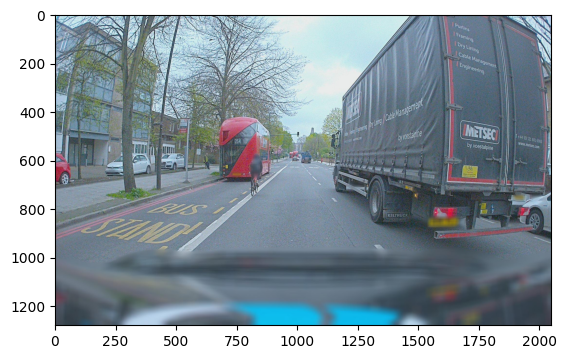

In [14]:
from matplotlib import pyplot as plt

dataset = Dataset(df, "evaluation/images/val")

data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

for images, questions, answers in data_loader:
    plt.imshow(images[0][0, ...])
    print(questions[0], answers[0])
    break

In [21]:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()

        self.llama_model = LlamaForCausalLM.from_pretrained("PY007/TinyLlama-1.1B-step-50K-105b")
        self.tokenizer = AutoTokenizer.from_pretrained("PY007/TinyLlama-1.1B-step-50K-105b")

        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

        self.projection_layer = torch.nn.Linear(512, 2048)
    
    def forward(self, images, question):
        device = "cuda"

        inputs = self.clip_processor(images=images, return_tensors="pt").to(device)

        with torch.no_grad():
            image_embeddings = self.clip_model.get_image_features(**inputs)

        projected_image_embeddings = self.projection_layer(image_embeddings.unsqueeze(0))

        text_inputs = self.tokenizer(question, return_tensors="pt").to(device)

        concatenated_embeddings = torch.cat((projected_image_embeddings, self.llama_model.get_input_embeddings()(text_inputs.input_ids)), dim=1)

        generate_ids = self.llama_model.generate(inputs_embeds=concatenated_embeddings, max_length=100)
        # output_text = self.tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

        return generate_ids

In [24]:
model = Model()
model.to("cuda")

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

tokenizer = AutoTokenizer.from_pretrained("PY007/TinyLlama-1.1B-step-50K-105b")

for images, questions, answers in data_loader:
    output = model(images[0], questions[0])

    ids = tokenizer(questions[0], return_tensors="pt").to(device).input_ids

    print(output.shape, ids.shape)

    loss = loss_fn(output.float(), ids.float())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(loss.item())
    break

torch.Size([1, 87]) torch.Size([1, 12])


RuntimeError: 0D or 1D target tensor expected, multi-target not supported